# Второе задание. Метрические алгоритмы классификации.

###### ФИО: Таскынов Ануар Гульденбекович

###### группа: 317

In [1]:
from sklearn.datasets import fetch_mldata
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

### Первый пункт: загрузка датасета MNIST.

In [2]:
mnist = fetch_mldata("MNIST original")

### Второй пункт: разбиение датасета на обучающую и тестовую выборку.

In [3]:
mnist_train, mnist_test = np.split(mnist.data, [60000])
mnist_target_train, mnist_target_test = np.split(mnist.target, [60000])

### Третий пункт: визуализация 5 случайных объектов из каждого из 10 классов.

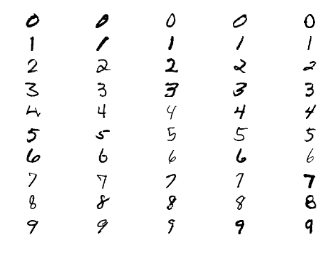

In [4]:
k = 1
for i in range(10):
    #находим 5 различных представителей класса
    index = np.random.choice(np.where(mnist_target_train == i)[0], 5, replace=False)
    #визуализируем их
    for j in range(5):
        plt.subplot(10, 5, k)
        plt.axis("off")
        plt.imshow(mnist_train[index[j]].reshape(28, 28), cmap="Greys")
        k += 1

### Четвертый пункт:

Выбор подмножества признаков:

In [5]:
from sklearn.neighbors import NearestNeighbors
features_1 = np.random.choice(np.arange(784), 10, replace=False)
features_2 = np.random.choice(np.arange(784), 20, replace=False)
features_3 = np.random.choice(np.arange(784), 100, replace=False)
all_features_mnist = np.arange(784)

Реализация матрицы евклидовых расстояний из первого задания:

In [6]:
def euclidian_distance(X, Y):
    D = np.zeros((X.shape[0], Y.shape[0]))
    for i in range(X.shape[0]):
        D[i] = np.sqrt(np.sum(np.square(X[i] - Y), axis=1))
    return D

Реализации алгоритма ближайших соседей без весов:

In [7]:
def my_algorithm(train, test, features, neighbor):
    res = np.zeros((test.shape[0], 5), dtype='int32')
    for i in range(test.shape[0]):
        test_elem = test[i][features].reshape(1, features.shape[0])
        euclidian_vector = euclidian_distance(test_elem, train[:, features])
        knn = np.argsort(euclidian_vector, axis=1)
        res[i] = knn[0][1:neighbor + 1]
    return res

def kd_tree_algorithm(train, test, features, neighbor):
    nbrs = NearestNeighbors(n_neighbors=neighbor, 
                            algorithm='kd_tree').fit(train[:,features])
    
    res = np.zeros((test.shape[0], neighbor), dtype='int32')
    step = 500 # размер блока
    size = test.shape[0] // step
    for i in range(0, size):
        left = i * step
        right = (i + 1) * step
        res[left: right] = nbrs.kneighbors(test[left: right, features])[1]
    #обрабатываем остаток
    if (test.shape[0] % step != 0):
        left = size * step
        right = test.shape[0]
        res[left: right] = nbrs.kneighbors(test[left: right, features])[1]
    
    return res

def brute_algorithm(train, test, features, neighbor, metrics='minkowski'):
    nbrs = NearestNeighbors(n_neighbors=neighbor, algorithm='brute', 
                            metric=metrics).fit(train[:,features])
    
    res = np.zeros((test.shape[0], neighbor), dtype='int32')
    step = 500 #размер блока
    size = test.shape[0] // step
    for i in range(0, size):
        left = i * step
        right = (i + 1) * step
        res[left: right] = nbrs.kneighbors(test[left: right, features])[1]
    #обрабатываем остаток
    if (test.shape[0] % step != 0):
        left = size * step
        right = test.shape[0]
        res[left: right] = nbrs.kneighbors(test[left: right, features])[1]
    
    return res

def ball_tree_algorithm(train, test, features, neighbor):
    nbrs = NearestNeighbors(n_neighbors=neighbor, 
                            algorithm='ball_tree').fit(train[:,features])
    
    res = np.zeros((test.shape[0], neighbor), dtype='int32')
    step = 500 #размер блока
    size = test.shape[0] // step
    for i in range(0, size):
        left = i * step
        right = (i + 1) * step
        res[left: right] = nbrs.kneighbors(test[left: right, features])[1]
    #обрабатываем остаток
    if (test.shape[0] % step != 0):
        left = size * step
        right = test.shape[0]
        res[left: right] = nbrs.kneighbors(test[left: right, features])[1]
    
    return res

В этом пункте были реализованы 4 алгоритма поиска ближайших соседей:
* собственная реализация на основе подсчета евклидова расстояния между объектами.
* алгоритм __brute__.
* алгоритм __kd_tree__.
* алгоритм __bal_tree__.

Так как некоторые алгоритмы хранят матрицу попарных расстояний между обучающими и тестовыми объектами (из-за чего происходит переполнение по памяти), все __brute__, __kd_tree__, __bal_tree__ обрабатывали тестовые объекты блоками с размером *step = 500*. В собственной реализации обрабатывался каждый тестовый объект.

In [8]:
#функция, возвращающая по номерам классов ближайших соседей номер класса
def num_class(knn):
    res = np.zeros(knn.shape[0])
    for i in range(knn.shape[0]):
        res[i] = np.argmax(np.bincount(knn[i]))
    return res

Также была написана функция, которая возвращает номер класса по номерам классов ближайших соседей из обучающей выборки по формуле:

$$
    res_i = argmax_{y\in Y} \sum_{j = 1}^{l} [knn_{i,j} = y]
$$

, где $l$ - количество ближайших соседей; $Y$ - множество всех классов (в случае MNIST: 0, 1, 2, ..., 9).

Проверка на время выполнения при различном количестве признаков:

In [10]:
start = time.clock()
my_1 = my_algorithm(mnist_train, mnist_test, features_1, 5)
t_my_1 = time.clock() - start

start = time.clock()
my_2 = my_algorithm(mnist_train, mnist_test, features_2, 5)
t_my_2 = time.clock() - start

start = time.clock()
my_3 = my_algorithm(mnist_train, mnist_test, features_3, 5)
t_my_3 = time.clock() - start

In [451]:
print('10: ', t_my_1)
print('20: ', t_my_2)
print('100: ', t_my_3)

10:  125.19069785618922
20:  191.30365770422213
100:  800.5445856842707


In [440]:
start = time.clock()
kd_1 = kd_tree_algorithm(mnist_train, mnist_test, features_1, 5)
t_kd_1 = time.clock() - start

start = time.clock()
kd_2 = kd_tree_algorithm(mnist_train, mnist_test, features_2, 5)
t_kd_2 = time.clock() - start

start = time.clock()
kd_3 = kd_tree_algorithm(mnist_train, mnist_test, features_3, 5)
t_kd_3 = time.clock() - start

In [452]:
print('10: ', t_kd_1)
print('20: ', t_kd_2)
print('100: ', t_kd_3)

10:  4.680853197205579
20:  14.807054000048083
100:  118.44362962117884


In [441]:
start = time.clock()
br_1 = brute_algorithm(mnist_train, mnist_test, features_1, 5)
t_br_1 = time.clock() - start

start = time.clock()
br_2 = brute_algorithm(mnist_train, mnist_test, features_2, 5)
t_br_2 = time.clock() - start

start = time.clock()
br_3 = brute_algorithm(mnist_train, mnist_test, features_3, 5)
t_br_3 = time.clock() - start

In [453]:
print('10: ', t_br_1)
print('20: ', t_br_2)
print('100: ', t_br_3)

10:  16.01518908290018
20:  15.778994244828937
100:  18.394672984897625


In [442]:
start = time.clock()
ball_1 = ball_tree_algorithm(mnist_train, mnist_test, features_1, 5)
t_ball_1 = time.clock() - start

start = time.clock()
ball_2 = ball_tree_algorithm(mnist_train, mnist_test, features_2, 5)
t_ball_2 = time.clock() - start

start = time.clock()
ball_3 = ball_tree_algorithm(mnist_train, mnist_test, features_3, 5)
t_ball_3 = time.clock() - start

In [454]:
print('10: ', t_ball_1)
print('20: ', t_ball_2)
print('100: ', t_ball_3)

10:  7.11027905010269
20:  23.68215708110074
100:  123.4175590488012


<center> <h4>Таблица работы алгоритмов:

|  features  | my_algoritm |   kd_tree   |   brute     |   ball_tree   |
|:----------:|:-----------:|:-----------:|:-----------:|:-------------:|
|   D = 10   |   2m 5.19s  |    4.68s    |   16.02s    |     7.11s     |
|   D = 20   |   3m 1.3s   |    14.8s    |   15.78s    |     23.7s     |
|   D = 100  |   13m 20s   |  1m 58.44s  |   18.39s    |    2m 3.42s   |

Собственная реализация уступает всем стандартным реализациям из sklearn из-за своей наивности. Алгоритм __brute__ работает одинаково несмотря на увеличение количества признаков. Примечательным является тот факт, что __ball_tree__ работает медленнее, чем __kd_tree__ (в обоих случаях признаковое пространство структурируется).

In [270]:
start = time.clock()
kd_tree_algorithm(mnist_train, mnist_test, all_features_mnist, 5)
print(time.clock() - start)

726.4864860703819


In [271]:
start = time.clock()
ball_tree_algorithm(mnist_train, mnist_test, all_features_mnist, 5)
print(time.clock() - start)

572.5072309698298


Однако применив методы __ball_tree__ и __kd_tree__ на всех признаках убеждаемся, что __bal_tree__ явно выигрывает по времени у __kd_tree__.

### Пятый пункт: генерация индексов для кросс-валидации.

In [11]:
def generate_index(N, D):
    index = np.arange(D)
    np.random.shuffle(index)
    test_index = np.array([], dtype='int32')
    train_index = np.array([], dtype='int32')
    step = D // N
    for i in range(N):
        left = i * step
        right = (i + 1) * step
        
        #тестовая валидационная выборка
        
        test_index_elem = index[left: right]
        test_index = np.append(test_index, test_index_elem)
        
        #обучающая валидационная выборка
        
        mask = np.ones(D, dtype='bool')
        mask[test_index_elem] = False
        train_index_elem = index[mask]
        train_index = np.append(train_index, train_index_elem)
    test_index = test_index.reshape(N, step)
    train_index = train_index.reshape(N, D - step)
    return (train_index, test_index)

Функция возвращает кортеж содержащий индексы обучающей и тестовой выборки: $100 * (1 - 1/N)$ объектов для обучения, а $1/N$ для тестирования алгоритма, где $N$ - число фолдов.

### Шестой пункт: оценка точности метода k-ближайших соседей при различных k.

In [12]:
#функция, которая считает процент совпадающих данных в двух массивах
def precision(x, y):
    return np.sum(x == y)/x.shape[0]

In [13]:
#функция, возвращающая точность при заданном количестве соседей и время выполнения функции
def accuracy(train, train_target, k, N, features, cross_val, metric='minkowski'):
    k_cnt = k.shape[0]
    prec = np.zeros((N, k_cnt))
    t = np.zeros((N, k_cnt))
    for fold in range(N):
        train_idx = cross_val[0][fold]
        test_idx = cross_val[1][fold]
        my_target = np.zeros(train[test_idx].shape[0])
        for neighbor in range(k_cnt):
            start = time.clock()
            knn = brute_algorithm(train[train_idx], train[test_idx], 
                                  features, k[neighbor], metrics=metric)
            t[fold][neighbor] = time.clock() - start
            knn = train_idx[knn]
            my_target = num_class(train_target[knn].astype('int32'))
            prec[fold][neighbor] = precision(my_target, train_target[test_idx])
    return (np.mean(prec, axis=0), np.mean(t, axis=0))

### Седьмой пункт: оценка точности методов при различных k и различной метрике.

In [14]:
k = np.arange(1, 11)
N = 3
cross_val_mnist = generate_index(N, mnist_target_train.shape[0])

In [16]:
euclid_mnist = accuracy(mnist_train, mnist_target_train, k, 
         N, all_features_mnist, cross_val_mnist)

In [17]:
cosine_mnist = accuracy(mnist_train, mnist_target_train, k,
                  N, all_features_mnist, cross_val_mnist, metric='cosine')

In [121]:
euclid_mnist

(array([ 0.98975   ,  0.97678333,  0.97988333,  0.9759    ,  0.97526667,
         0.97368333,  0.97293333,  0.97155   ,  0.97065   ,  0.96966667]),
 array([ 44.20737731,  44.59978496,  44.97660889,  48.44955752,
         48.46381144,  48.56845146,  48.52353302,  48.3893688 ,
         48.98393099,  48.93317988]))

In [122]:
cosine_mnist

(array([ 0.99088333,  0.98115   ,  0.98233333,  0.98031667,  0.97916667,
         0.97805   ,  0.97655   ,  0.9755    ,  0.97448333,  0.97341667]),
 array([ 52.04902747,  56.38391391,  55.40565296,  59.06126535,
         60.18520035,  62.96733682,  65.69101677,  64.41453395,
         60.2893135 ,  62.08593324]))

Для данного пункта был выбран __brute_algorithm__, так как время выполнения этого алгоритма практически не зависит от увеличения количества признаков. В данном пункте нужно было сравнить точность алгоритма ближайших соседей в зависимости от некоторых факторов:
* выбор метрики (косинусная и евклидовая)  
* количество соседей k от 1 до 10. 

Результаты экспериментов показали, что точность при __косинусной метрике выше__, чем при __евклидовой__. Также можно заметить, что количество соседей не так сильно влият на качество классификатора, откуда следует, что для определенных задач нужно экспериментально находить наилучшее количество соседей. В данной задаче __k = 1__ является оптимальным параметром.

<center> <h4>Таблица работы алгоритмов (точность):

|metric | k = 1 | k = 2 | k = 3 | k = 4 | k = 5 | k = 6 | k = 7 | k = 8 | k = 9 | k = 10 |
|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:------:|
|euclid |0.989|0.976|0.979|0.976|0.975|0.973|0.972|0.972|0.970|0.969|
|cosine |0.990|0.981|0.982|0.9803|0.9791|0.978| 0.976|0.975|0.974|0.973|

Алгоритм ближайших соседей при __косинусной__ метрике работает __дольше__, чем при __евклидовой__:

<center> <h4>Таблица работы алгоритмов (время выполнения):

|metric | k = 1 | k = 2 | k = 3 | k = 4 | k = 5 | k = 6 | k = 7 | k = 8 | k = 9 | k = 10 |
|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:------:|
|euclid |44.2s|44.6s|44.9s|48.4s|48.4s|48.5s|48.5s|48.3s|48.9s|48.9s|
|cosine |52s|56.3s|55.4s|59s|60.1s|62.9s|65.6s|64.4s|60.2s|62s|

### Восьмой пункт: 

Реализация алгоритма с весами:

In [18]:
def weight_brute(train, test, features, neighbor, eps, metrics='minkowski'):
    nbrs = NearestNeighbors(n_neighbors=neighbor, algorithm='brute', 
                            metric=metrics).fit(train[:,features])
    res = np.zeros((test.shape[0], neighbor), dtype='int32')
    dis = np.zeros((test.shape[0], neighbor))
    step = 500
    size = test.shape[0] // step
    for i in range(0, size):
        left = i * step
        right = (i + 1) * step
        dis[left: right], res[left: right] = nbrs.kneighbors(test[left: right, features])
        dis[left: right] = 1 / (dis[left: right] + eps)
    if (test.shape[0] % step != 0):
        left = size * step
        right = test.shape[0]
        dis[left: right], res[left: right] = nbrs.kneighbors(test[left: right, features])
        dis[left: right] = 1 / (dis[left: right] + eps)
    return (dis, res)

Данная функция является модификацией функции __brite_algorithm__. Функция возвращает кортеж из ближайших соседей и весов для этих соседей. Веса $dis$ предлаегается считать по формуле:

$$
    dis = 1 / (distance + eps)
$$

, где $distance$ - расстояние между объектами, $eps$ - малое число.

In [19]:
def num_class_weight(knn, target_train):
    test_cnt = knn[1].shape[0]
    neighbor = knn[1].shape[1]
    near_neighbor = knn[1] # матрица ближайших соседей
    dis = knn[0] # матрица весов
    class_cnt = target_train.shape[0]
    weight = np.zeros((test_cnt, class_cnt))
    for i in range(test_cnt):
        for j in range(neighbor):
            weight[i][target_train[near_neighbor[i][j]]] += dis[i][j]
    return np.argmax(weight, axis=1)

Функция __num_class_weight__ находит класс для объекта по кортежу из ближайших соседей и их весов по формуле и из ответов на обучающей выборке:

$$
    res_i = argmax_{y\in Y} \sum_{j = 1}^{l} [train_{knn_{i,j}} = y] * weight_{i, j}
$$

, где $Y$ - множество всех классов, $train$ - ответы на обучающей выборке, $knn$ - матрица индексов ближайших соседей из обучающей выборки, $weight$ - веса, $l$ - количество соседей.

In [20]:
#функция для алгоритмов с весами, возвращающая точность 
#при заданном количестве соседей и время выполнения
def accuracy_weight(train, train_target, k, N, features, eps, cross_val, metric='minkowski'):
    k_cnt = k.shape[0]
    prec = np.zeros((N, k_cnt))
    t = np.zeros((N, k_cnt))
    for fold in range(N):
        train_idx = cross_val[0][fold]
        test_idx = cross_val[1][fold]
        my_target = np.zeros(train[test_idx].shape[0])
        for neighbor in range(k_cnt):
            start = time.clock()
            dis, knn = weight_brute(train[train_idx], train[test_idx], 
                                features, k[neighbor], eps, metrics=metric)
            t[fold][neighbor] = time.clock() - start
            knn = train_idx[knn]
            my_target = num_class_weight((dis, knn), train_target)
            prec[fold][neighbor] = precision(my_target, train_target[test_idx])
    return (np.mean(prec, axis=0), np.mean(t, axis=0))

In [21]:
euclid_weight_mnist = accuracy_weight(mnist_train, mnist_target_train, 
                            k, N, all_features_mnist, 0.01, cross_val_mnist)

In [22]:
cosine_weight_mnist = accuracy_weight(mnist_train, mnist_target_train, 
                            k, N, all_features_mnist, 0.01, cross_val_mnist, metric='cosine')

In [80]:
euclid_weight_mnist

(array([ 0.98975   ,  0.98975   ,  0.99051667,  0.99068333,  0.98961667,
         0.99003333,  0.98931667,  0.98956667,  0.98868333,  0.9887    ]),
 array([ 43.76388024,  44.44991465,  45.31172627,  48.83384237,
         52.72570559,  54.58619858,  49.20270825,  48.89823697,
         48.92474496,  48.98374282]))

In [81]:
cosine_weight_mnist

(array([ 0.99088333,  0.99088333,  0.99145   ,  0.99175   ,  0.99108333,
         0.9914    ,  0.99065   ,  0.99095   ,  0.99056667,  0.99041667]),
 array([ 50.76833824,  51.88875055,  52.68251172,  57.70069031,
         57.22107422,  57.48450372,  57.25295999,  57.36884193,
         57.0452928 ,  57.04908629]))

<center> <h4>Таблица работы алгоритмов при весах (точность):

|metric | k = 1 | k = 2 | k = 3 | k = 4 | k = 5 | k = 6 | k = 7 | k = 8 | k = 9 | k = 10 |
|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:------:|
|w_euclid |0.989|0.989|0.9905|0.9906|0.989|0.990|0.9893|0.9895|0.9886|0.9887|
|w_cosine |0.9908|0.9908|0.9914|0.9917|0.9910|0.9914|0.9906|0.9909|0.9905|0.9904|

<center> <h4>Таблица работы алгоритмов при весах (время выполнения):

|metric | k = 1 | k = 2 | k = 3 | k = 4 | k = 5 | k = 6 | k = 7 | k = 8 | k = 9 | k = 10 |
|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:------:|
|w_euclid |43.7s|44.4s|45.3s|48.8s|52.7s|54.5s|49.2s|48.8s|48.9s|48.9|
|w_cosine |50.7s|51.8s|52.6s|57.7s|57.2s|57.4s|57.2s|57.3s|57s|57s|

По данной таблице можно сделать вывод, что также как и без весов при __косинусной метрике__ алгоритм ближайших соседей работает __дольше__, чем при __евклидовой__. Также __евклидова метрика__ отстает по качеству от __косинусной__, показывая точность на __1% хуже__, чем при косинусной метрике. Также предлагается сравнить с классификатором без весов:

|metric | k = 1 | k = 2 | k = 3 | k = 4 | k = 5 | k = 6 | k = 7 | k = 8 | k = 9 | k = 10 |
|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:------:|
|w_euclid |0.989|0.989|0.9905|0.9906|0.989|0.990|0.9893|0.9895|0.9886|0.9887|
|w_cosine |0.9908|0.9908|0.9914|0.9917|0.9910|0.9914|0.9906|0.9909|0.9905|0.9904|
|euclid |0.989|0.976|0.979|0.976|0.975|0.973|0.972|0.972|0.970|0.969|
|cosine |0.990|0.981|0.982|0.9803|0.9791|0.978| 0.976|0.975|0.974|0.973|

При __k=1__ нет различий между алгоритмами с весами и без весов. А при увеличении количество соседей качество в алгоритме с весами __лучше__.

### Девятый пункт:

По результатам экспериментов на кросс-валидации алгоритм ближайших соседей с __косинусной метрикой__ и с __4 соседями__ показывает наилучшую точность, поэтому запускаем этот алгоритм для тестовой и обучающей выборок.

In [23]:
cos_weight_brute = weight_brute(mnist_train, mnist_test, 
                        all_features_mnist, 4, 0.01, metrics='cosine')

In [24]:
class_of_test = num_class_weight(cos_weight_brute, mnist_target_train)

In [25]:
prec_mnist = precision(class_of_test, mnist_target_test)

In [26]:
prec_mnist * 100

97.519999999999996

Итоговая точность - __97.5%__, однако при кросс-валидации точность была - __99.2%__. Сравнивая с наилучшими алгоритмами на данном датасете в Интернете можно сделать вывод, что алгоритм __k Nearest Neighbors__ - далеко не лучший по точности.

### Десятый пункт:

Функция, показывающая объекты на которых были допущены ошибки:

In [188]:
def error(answer, test_target, test, class_cnt):
    idx_of_error = np.where(answer != test_target)[0] #индексы, на которых были допущены ошибки
    k = 1
    new = test_target[idx_of_error]
    for i in range(class_cnt):
        index = np.where(new == i)[0][0]
        plt.subplot(1, class_cnt, k)
        plt.axis("off")
        print(answer[idx_of_error[index]])
        plt.imshow(test[idx_of_error[index]].reshape(28, 28), 
                    cmap="Greys")
        k += 1

7
2
7
7
9
4
0
4
0
8


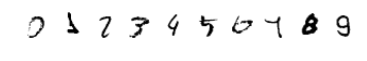

In [189]:
error(class_of_test, mnist_target_test, mnist_test, 10)

На основе работы функции можно сделать вывод, что классификатор ошибается на объектах, схожих по написанию или где четко не прорисованы линии цифры:
* объект 0 он отнес к классу "7", так как в визуализации объекта отсутствует левая граница 0.
* объект 2 отнес к классу "7", так как нижняя черта в визуализации объекта 2 отсутсвует.
* объект 6 отнес к классу "0" и т.д.

In [220]:
from sklearn.metrics import confusion_matrix

In [38]:
confusion_matrix(mnist_target_test, class_of_test)

array([[ 977,    1,    0,    0,    0,    0,    1,    1,    0,    0],
       [   0, 1129,    3,    1,    0,    0,    2,    0,    0,    0],
       [   8,    0, 1009,    1,    1,    0,    0,    8,    5,    0],
       [   0,    1,    3,  976,    1,   12,    0,    4,    9,    4],
       [   2,    1,    0,    0,  946,    0,    6,    2,    0,   25],
       [   4,    0,    0,    9,    1,  863,    7,    1,    4,    3],
       [   3,    3,    0,    0,    1,    3,  948,    0,    0,    0],
       [   2,   10,    4,    0,    1,    0,    0,  998,    0,   13],
       [   7,    1,    2,    9,    3,    3,    5,    4,  936,    4],
       [   7,    7,    2,    5,    7,    3,    1,    4,    3,  970]])

Благодаря матрице ошибок можно сделать вывод, что наибольшее количесто раз классификатор ошибался на классе "4", выдавая ее за класс "9". Наибольшее количество правильно обработанных объектов находится в классе "1".

### Одиннадцатый пункт: загрузка датасета 20 newsgroups

In [27]:
from sklearn.datasets import fetch_20newsgroups

Загружаем объекты датасета:

In [28]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

### Двенадцатый пункт:

Перевод всех документов в нижний регистр:

In [29]:
newsgroups_train = list(map(lambda x: x.lower(), newsgroups_train.data))

Замена всех символов, не являющихся буквами и цифрами на пробелы:

In [30]:
for i in range(len(newsgroups_train)):
    s = ''.join(map(lambda x: [' ', x][x.isalnum()], 
                        list(newsgroups_train[i])))
    newsgroups_train[i] = s

### Тринадцатый пункт: разделение документов на слова.

In [31]:
newsgroups_train = list(map(lambda x: x.split(), newsgroups_train))

### Четырнадцатый пункт: преобразование датасета в разреженную матрицу.

In [32]:
from scipy.sparse import csr_matrix

Находим все слова из всех документов:

In [33]:
from collections import defaultdict
import functools
all_words_train = list(functools.reduce(lambda x, y: x + y, newsgroups_train))
all_words_train = sorted(list(set(all_words_train)))

Функция, которая принимает все слова из всех документов и сами документы и возвращает параметры для построения разреженной матрицы __csr_matrix__:
* *data* - массив, который хранит ненулевые элементы.
* *indices* - конкатенация массивов *no_null*, которые хранят индексы ненулевых элементов.
* *indptr* - массив: indptr[i] = indptr[i - 1] + size(no_null).

In [38]:
def param_for_csr(all_words, document_words):
    size_of_data = 0
    dictionary = defaultdict(int)
    for document in document_words:
        for word in document:
            dictionary[word] += 1
        for value in dictionary.values():
            size_of_data += 1
        dictionary.clear()
    data = np.zeros(size_of_data, dtype='int32')
    indices = np.zeros(size_of_data, dtype='int32')
    indptr = np.zeros(len(document_words) + 1, dtype='int32')
    k = 0
    l = 1
    for document in document_words:
        for word in all_words:
            dictionary[word]
        for word in document:
            dictionary[word] += 1
        dic = sorted(dictionary.items())
        dic = np.asarray(dic)[:,1].astype('int32')
        no_null = np.where(dic != 0)[0]
        indptr[l] = indptr[l - 1] + no_null.size
        l += 1
        for i in no_null:
            data[k] = dic[i]
            indices[k] = i
            k += 1
        dictionary.clear()
    return (data, indices, indptr)

Создается __csr_matrix__, так как в данном датасете матрица "объект-признак" имеет большую размерность и вследствие чего происходило бы переполнение по памяти.   

In [46]:
start = time.clock()
param_csr = param_for_csr(all_words_train, newsgroups_train)
print(time.clock() - start)

4413.6244471910795


In [47]:
CSR = csr_matrix(param_csr)

In [57]:
CSR

<11314x98749 sparse matrix of type '<class 'numpy.int32'>'
	with 1147082 stored elements in Compressed Sparse Row format>

, где $CSR_{i, j}$ - количество слов j в i-ом документе.

### Пятнадцатый пункт: tf-idf преобразование.

In [49]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_idf = TfidfTransformer()

In [50]:
tf_idf.fit(CSR)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [51]:
CSR_tf_idf = tf_idf.transform(CSR)

In [58]:
CSR_tf_idf

<11314x98749 sparse matrix of type '<class 'numpy.float64'>'
	with 1147082 stored elements in Compressed Sparse Row format>

Было сделано tf-idf преобразование датасета, которое показывает важность слова в данном документе. Были использованы параметры по умолчанию. Предполагается, что благодаря этому преобразованию __качество__ классификатора __улучшится__.

### Шестнадцатый пункт:

Генерируем индексы для кросс-валидации с помощью функции из 5 пункта.

In [59]:
cross_val_doc = generate_index(3, CSR.shape[0])

In [60]:
newsgroups_train_target = fetch_20newsgroups(subset='train', 
                            remove=('headers', 'footers', 'quotes')).target

In [62]:
all_features_doc = np.arange(CSR.shape[1])

In [72]:
euclid_doc = accuracy(CSR, newsgroups_train_target, 
                            k, N, all_features_doc, cross_val_doc)

In [73]:
cosine_doc = accuracy(CSR, newsgroups_train_target, k, 
                    N, all_features_doc, cross_val_doc, metric='cosine')

In [76]:
euclid_doc_tf_idf = accuracy(CSR_tf_idf, newsgroups_train_target, k, 
                    N, all_features_doc, cross_val_doc)

In [77]:
cosine_doc_tf_idf = accuracy(CSR_tf_idf, newsgroups_train_target, k, 
                    N, all_features_doc, cross_val_doc, metric='cosine')

In [74]:
euclid_doc

(array([ 0.7211173 ,  0.46291877,  0.39070096,  0.3713427 ,  0.36091222,
         0.34809511,  0.33695748,  0.3309467 ,  0.32440555,  0.31689207]),
 array([ 2.19142976,  2.19811643,  2.21393082,  2.36384653,  2.37970066,
         2.34943761,  2.39878851,  2.87642661,  2.82023863,  2.36087361]))

In [75]:
cosine_doc

(array([ 0.74286219,  0.57314594,  0.4970388 ,  0.4464775 ,  0.41412534,
         0.39573941,  0.37770706,  0.36603907,  0.36091222,  0.35065853]),
 array([ 2.1343087 ,  2.15578444,  2.17951347,  2.3685273 ,  2.45249676,
         2.39991739,  2.36687577,  2.36496922,  2.36947328,  2.37194801]))

In [78]:
euclid_doc_tf_idf

(array([ 0.70202422,  0.37744188,  0.28100415,  0.2962079 ,  0.27419783,
         0.25501635,  0.24202245,  0.22734907,  0.21912844,  0.20931672]),
 array([ 2.34546121,  2.37567966,  2.3669438 ,  2.54118291,  2.59984575,
         2.6422005 ,  2.67724039,  2.61211601,  2.64778593,  2.6951641 ]))

In [79]:
cosine_doc_tf_idf

(array([ 0.84478034,  0.72703969,  0.69433395,  0.67683196,  0.66339609,
         0.65437992,  0.64527535,  0.6373199 ,  0.62724299,  0.61981791]),
 array([ 2.28395137,  2.29857267,  2.30367992,  2.49086984,  2.51364724,
         2.48056509,  2.51531259,  2.51399147,  2.498755  ,  2.53571525]))

<center> <h4>Таблица работы алгоритмов (точность):

|metric | k = 1 | k = 2 | k = 3 | k = 4 | k = 5 | k = 6 | k = 7 | k = 8 | k = 9 | k = 10 |
|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:------:|
|euclid |0.721|0.462|0.39|0.371|0.36|0.348|0.337|0.33|0.324|0.317|
|cosine |0.743|0.573|0.497|0.446|0.414|0.396|0.378| 0.366|0.36|0.35|
|euclid_tf_idf |0.7|0.377|0.281|0.296|0.274|0.255|0.242|0.227|0.219|0.209|
|cosine_tf_idf |0.8447|0.727|0.694|0.677|0.663|0.654|0.645|0.637|0.627|0.62|

По этой таблице можно сделать вывод, что при увеличении количества соседей ухудшается качество классификатора. Также, как и в случае с датасетом *Mnist*: __косинусная__ метрика __лучше__, чем __евклидова__. __Tf_idf__ преобразование __ухудшает__ качество при __евклидовой метрике__, но заметно __улучшает__ для __косинусной метрики__. Все алгоритмы работают работают одинаково по времени.

In [95]:
euclid_doc_weight = accuracy_weight(CSR, newsgroups_train_target, k, 
                    N, all_features_doc, 0.01, cross_val_doc)

In [96]:
cosine_doc_weight = accuracy_weight(CSR, newsgroups_train_target, k, 
                    N, all_features_doc, 0.01, cross_val_doc, metric='cosine')

In [97]:
euclid_doc_weight_tf_idf = accuracy_weight(CSR_tf_idf, newsgroups_train_target, k, 
                            N, all_features_doc, 0.01, cross_val_doc)

In [98]:
cosine_doc_weight_tf_idf = accuracy_weight(CSR_tf_idf, newsgroups_train_target, k, 
                            N, all_features_doc, 0.01, cross_val_doc, metric='cosine')

In [99]:
euclid_doc_weight

(array([ 0.7211173 ,  0.72076372,  0.72032175,  0.72023336,  0.72032175,
         0.72076372,  0.72244321,  0.72058694,  0.72129409,  0.7210289 ]),
 array([ 2.28206956,  2.31056752,  2.34065227,  2.46420146,  2.4623982 ,
         2.45827022,  2.43533545,  2.44652184,  2.46401145,  2.47525731]))

In [100]:
cosine_doc_weight

(array([ 0.74286219,  0.74242022,  0.74215504,  0.74197826,  0.7399452 ,
         0.73826571,  0.73879608,  0.73897286,  0.7384425 ,  0.73729338]),
 array([ 2.49826905,  2.52647713,  2.61878808,  2.82585182,  2.7498566 ,
         3.11624301,  3.27936218,  3.10725121,  2.83260178,  2.95845727]))

In [101]:
euclid_doc_weight_tf_idf

(array([ 0.70202422,  0.70202422,  0.7008751 ,  0.70052152,  0.69884204,
         0.69610183,  0.69521789,  0.69132856,  0.69150535,  0.69017944]),
 array([ 2.88126949,  3.15542706,  2.83893633,  2.91384885,  3.20270759,
         2.95413652,  2.53794537,  2.52225572,  2.55219007,  2.53717112]))

In [102]:
cosine_doc_weight_tf_idf

(array([ 0.84478034,  0.84433837,  0.84318925,  0.84283568,  0.84221692,
         0.84089101,  0.83912313,  0.83797401,  0.83832759,  0.83576417]),
 array([ 2.28313857,  2.35169102,  2.39799597,  2.7077245 ,  2.71314058,
         2.63998038,  2.62859965,  2.5534908 ,  2.61349398,  2.63525645]))

<center> <h4>Таблица работы алгоритмов (точность):

|metric | k = 1 | k = 2 | k = 3 | k = 4 | k = 5 | k = 6 | k = 7 | k = 8 | k = 9 | k = 10 |
|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:------:|
|euclid_w|0.721|0.7207|0.7203|0.7202|0.7203|0.7207|0.722|0.7205|0.7212|0.721|
|cosine_w|0.7429|0.7424|0.7422|0.742|0.74|0.738|0.739|0.7389|0.7384|0.7373|
|euclid_tf_idf_w|0.702|0.702|0.7008|0.7005|0.699|0.696|0.695|0.691|0.6915|0.69|
|cosine_tf_idf_w|0.8447|0.8443|0.8431|0.8428|0.8422|0.8409|0.8391|0.8379|0.8383|0.8357|

Алгоритм с __косинусной метрикой__ с весами с __tf-idf__ преобразованием. Самым оптимальным алгоритмом является алгоритм при одном соседе с __косинусной метрикой__ с весами и __tf-idf__ преобразованием.

### Семнадцатый пункт:

Загружаем тестовую выборку, ответы на тестовой выборке, преобразуем всё в разреженную матрицу.

In [125]:
newsgroups_test = fetch_20newsgroups(subset='test', 
                            remove=('headers', 'footers', 'quotes'))

newsgroups_test_target = fetch_20newsgroups(subset='test', 
                            remove=('headers', 'footers', 'quotes')).target

newsgroups_test = list(map(lambda x: x.lower(), newsgroups_test.data))

for i in range(len(newsgroups_test)):
    s = ''.join(map(lambda x: [' ', x][x.isalnum()], 
                        list(newsgroups_test[i])))
    newsgroups_test[i] = s

newsgroups_test = list(map(lambda x: x.split(), newsgroups_test))

all_words_test = list(functools.reduce(lambda x, y: x + y, newsgroups_test))
all_words_test = sorted(list(set(all_words_test)))

In [126]:
all_words = list(functools.reduce(lambda x, y: x + y, [all_words_train, all_words_test]))
all_words = sorted(list(set(all_words)))

In [145]:
start = time.clock()
param_train = param_for_csr(all_words, newsgroups_train)
print(time.clock() - start)

11800.424427374237


In [142]:
start = time.clock()
param_test = param_for_csr(all_words, newsgroups_test)
print(time.clock() - start)

8035.360963745843


Так как количество термов в обучающей и тестовой выборке __отличаются__ передаем параметр shape=(M, N):

In [175]:
M_train = len(newsgroups_train)
N_train = len(all_words)
CSR_train = csr_matrix(param_train, shape=(M_train, N_train))

In [177]:
M_test = len(newsgroups_test)
N_test = len(all_words)
CSR_test = csr_matrix(param_test, shape=(M_test, N_test))

In [178]:
CSR_train 

<11314x130098 sparse matrix of type '<class 'numpy.int32'>'
	with 1147082 stored elements in Compressed Sparse Row format>

In [179]:
CSR_test

<7532x130098 sparse matrix of type '<class 'numpy.int32'>'
	with 731378 stored elements in Compressed Sparse Row format>

__Tf-idf__ преобразование разреженной матрицы:

In [180]:
tf_idf = TfidfTransformer()
tf_idf.fit(CSR_train)
CSR_train_tf_idf = tf_idf.transform(CSR_train)

In [181]:
tf_idf = TfidfTransformer()
tf_idf.fit(CSR_test)
CSR_test_tf_idf = tf_idf.transform(CSR_test)

Применяем лучший алгоритм с кросс-валидации:

In [182]:
all_features_doc = np.arange(len(all_words))
cos_weight_brute_doc = weight_brute(CSR_train_tf_idf, CSR_test_tf_idf, 
                        all_features_doc, 1, 0.01, metrics='cosine')

In [185]:
class_of_test_doc = num_class_weight(cos_weight_brute_doc, 
                                     newsgroups_train_target)

In [186]:
prec_doc = precision(class_of_test_doc, newsgroups_test_target)

In [187]:
prec_doc

0.50092936802973975

Итоговая точность оказалась на __30%__ хуже, чем при кросс-валидации.

### Восемнадцатый пункт:

Перепишем функцию визуализации ошибок:

In [215]:
def error_doc(answer, test_target, test, class_cnt, target_names):
    idx_of_error = np.where(answer != test_target)[0] #индексы, на которых были допущены ошибки
    k = 1
    new = test_target[idx_of_error]
    print(idx_of_error)
    for i in range(class_cnt):
        index = np.where(new == i)[0][0]
        print(target_names[answer[idx_of_error[index]]], ":")
        print(test[idx_of_error[index]])
        k += 1

Визуализация объектов, на которых были допущены ошибки:

In [216]:
class_cnt = max(newsgroups_test_target) + 1
target_names_doc = fetch_20newsgroups(subset='train')
target_names_doc = target_names_doc.target_names

Наименования классов:

target_names_doc

In [217]:
error_doc(class_of_test_doc, newsgroups_test_target, newsgroups_test, class_cnt, target_names_doc)

[   0    2    4 ..., 7527 7529 7530]
talk.politics.mideast :
['in', 'a', 'word', 'yes']
talk.politics.misc :
['this', 'is', 'an', 'invitation', 'to', 'send', 'articles', 'to', 'the', 'informatica', 'magazine', 'the', 'first', 'fully', 'international', 'issue', 'has', 'been', 'published', 'and', 'echoes', 'are', 'quite', 'favourable', 'for', 'any', 'information', 'contact', 'matjaz', 'gams', 'ijs', 'si', 'dear', 'colleague', 'april', '25', '1993', 'number', '1', 'of', 'volume', '17', 'of', 'informatica', 'is', 'now', 'out', 'of', 'print', 'and', 'some', 'of', 'you', 'will', 'receive', 'it', 'in', 'a', 'week', 'or', 'so', 'as', 'you', 'will', 'see', 'the', 'journal', 'is', 'structured', 'in', 'the', 'following', 'way', 'the', 'editorial', 'first', 'page', 'profiles', 'second', 'page', 'biography', 'of', 'an', 'editor', 'in', 'this', 'issue', 'terry', 'winograd', 'the', 'edited', 'part', 'of', 'papers', 'pp', '3', '80', 'mission', 'and', 'research', 'reports', 'a', 'plan', 'for', 'knowled

Ошибки происходят из-за схожести классов и нехватки ключевых слов и термов.

Матрица ошибок:

In [225]:
print(confusion_matrix(newsgroups_test_target, class_of_test_doc))

[[157   2   3   3   2   0   0  12   2   2   3   8   3   6   5  36   6  22
   12  35]
 [  3 183  28  13  12  32   8  11   8   5   4  19   7   8   6  11   4   7
   14   6]
 [  5  22 169  33  18  21  15  20   5   5   3   6   4   7  10  10   2  13
   11  15]
 [  0  17  36 213  29   4  17  12   1   3   1  11  18   4   2   2   1  10
    6   5]
 [  1  11  14  49 187   9  10  18   1   1   2   6  12   8   3  18   6  11
   15   3]
 [  1  34  26   7   3 249   4   6   2  11   4  11   3   3   6   4   3   6
    8   4]
 [  1   3  11  39  29   6 184  26   8  20   6   4  11   6   9   6   2   7
    3   9]
 [  6  10   0   4   5   1  11 217  22   6   4   6  18   3   8  17   7  24
   18   9]
 [  7   3   7   5   7   3   3  35 203   3   2   8   8   5   9  21   7  40
   11  11]
 [  7   2   4   5   2   1   3  22   5 218  24   3   2   5   4  22   3  47
   12   6]
 [  6   3   3   0   2   1   3  10   6  28 268   3   4   4   3  13   3  31
    3   5]
 [  9   9   4   4   5   1   4  17   6   2  12 230   2   5   1  17

По матрице ошибок можно сделать вывод, что наибольшее количество правильно отклассифицированных текстов на тематику __'comp.windows.x'__. Наибольшее количество неправильно отклассифицированных текстов на тематику __'talk.politics.misc'__: классификатор выдает ее за __'talk.politics.guns'__ из-за схожести текстов.

In [230]:
cnt_empty = 0
for text in newsgroups_train:
    if (len(text) == 0):
        cnt_empty += 1
print(cnt_empty)

310


Важно заметить, что также в датасете есть тексты с __пустым__ содержанием.

### Девятнадцатый пункт:

Используемые алгоритмы:

1. В ходе данного задания были изучены различные реализации алгоритма k ближайших соседей:
    * kd_tree
    * ball_tree
    * brute
2. В результате экспериментов __brute__ показал свою "независимость" от количества признаков, в отличие от __kd_tree__ и __ball_tree__.
3. Были проведены эксперименты на различном количестве соседей k от 1 до 10. Как оказалось, количество соседей не так сильно влияют на точность алгоритма.
4. Были проведены эксперименты на двух разных метриках:
    * евклидова
    * косинусная
5. Косинусная метрика работает дольше, чем евклидова из-за двойного подсчета нормы.
6. Косинусная метрика показывает лучшую точность, чем евклидова.
7. При добавлении весов улучшается точность как косинусной так и евклидовой метрики.

Работа с датасетами:

1. MNIST:
    * На MNIST наилучшую точность показал алгоритм с косинусой метрикой и с добавленными весами, при этом точность на тестовой выборке составила 97,5%, что отличается с точностью при кросс-валидации - 99,17%.
    * Большинство ошибок были допущены на цифрах, одинаковых по написанию, а также на цифрах, где отсутвуют четкие линии.
    * Классом на котором допущено было наибольшее количество ошибок является "4" (классификатор путает его с классом "9").
2. 20newsgroups:
    * На 20newsgroups наилучшую точность показал алгоритм с косинусной метрикой с tf-idf преобразованием, весами и при одном соседе, при этом точность на тестовой выборке составила 50%, что очень сильно отличается от точности при кросс-валидации - 84,47 %.
    * Большинство ошибок были допущены из-за нехватки слов в документе, а также из-за схожести по тематики тексто из различных классов.
    * При выводе матрицы ошибок тексты из класса 'talk.politics.misc' классификатор выдает за класс 'talk.politics.guns'
    * Также в этом датасете существуют пустые тексты (310).
    
Работа с параметрами:

1. Важно заметить, что количество соседей не так сильно влияют на точность классификатора.
2. Выбор метрики является важной частью решения задачи, так как результаты экспериментов показали косинусная метрика гораздо лучше классифицирует объекты, чем евклидова.
3. Введение весов также является важным параметром для улучшения точности. Так, при k = 5 при евклидовой метрике без весов на датасете MNIST точность на кросс-валидации составил 97,5%, а при добавлении весов: 98,9%.